<a href="https://colab.research.google.com/github/jordanbell2357/signal-processing/blob/main/Karplus_Strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def KS_1(x, N):
    # given the initial buffer x, produce a N-sample output
    #  by concatenating identical copies of the buffer
    y = x
    while len(y) < N:
        # keep appending until we reach or exceed the required length
        y = np.append(y, x)
    # trim the excess
    y = y[0:N+1]
    return y

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [3]:
plt.rcParams["figure.figsize"] = (14,4)

In [4]:
Fs = 16000 # 16 KHz sampling rate

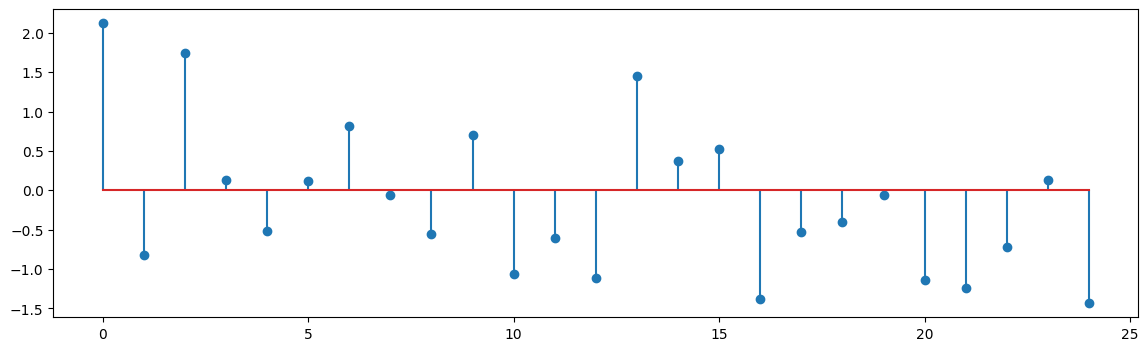

In [5]:
b = np.random.randn(25)
plt.stem(b);

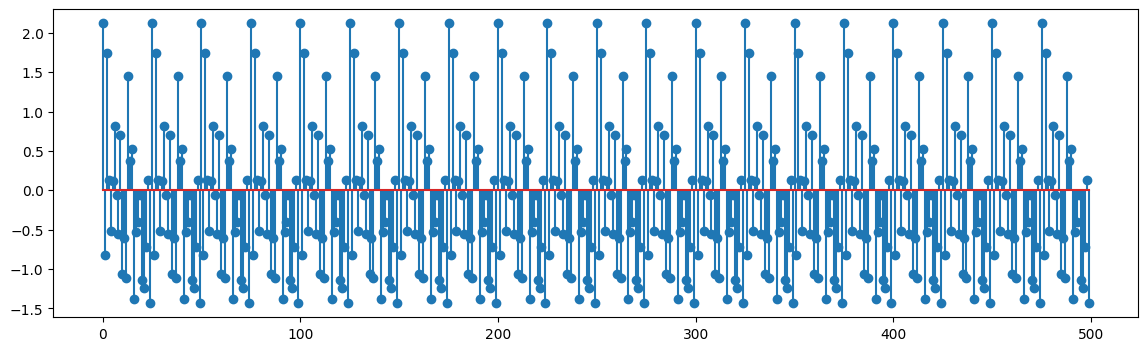

In [6]:
y = KS_1(b, Fs * 2)

# we can look at a few periods:
plt.stem(y[0:500]);

In [7]:
IPython.display.Audio(y, rate=Fs)

In [8]:
# let's play an octave lower: just double the initial buffer's length
IPython.display.Audio(KS_1(np.random.rand(100), Fs * 2), rate=Fs)

In [9]:
def KS_2(x, N):
    # length of the input
    M = len(x)
    # prepare the output
    y = np.zeros(N)
    # this is NOT an efficient implementation, but it shows the general principle
    # we assume zero initial conditions (y[n]=0 for n < 0)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + (y[n-M] if n-M >= 0 else 0)
    return y

In [10]:
# it should still work
IPython.display.Audio(KS_2(np.random.rand(50), Fs * 2), rate=Fs)

In [11]:
def KS_3(x, N, alpha = 0.99):
    M = len(x)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
    return y

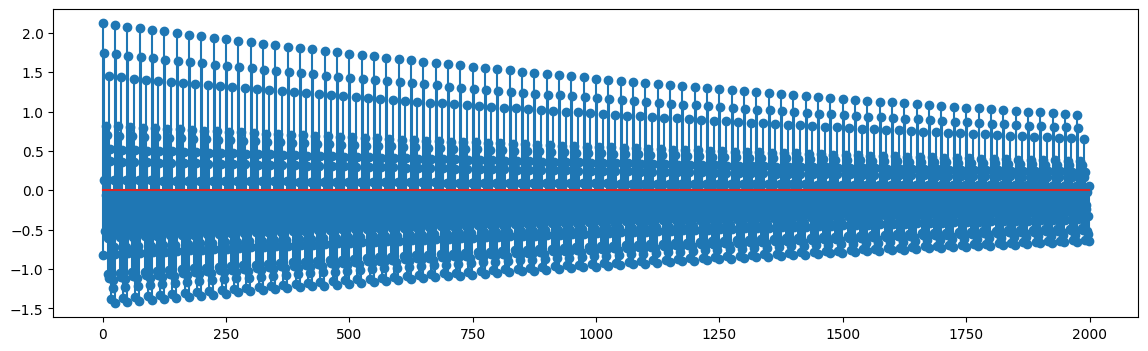

In [12]:
y = KS_3(b, Fs * 2)
plt.stem(y[0:2000]);

In [13]:
IPython.display.Audio(y, rate=Fs)

There is just one last detail (the devil's in the details, here as everywhere else). Consider the output of a dampened K-S loop; every time the initial buffer goes through the loop, it gets multiplied by $\alpha$ so that we can write
$$
  y[n] = \alpha^{\lfloor n/M \rfloor}x[n \mod M]
$$
(think about it and it will make sense). What that means is that the decay envelope is dependent on both $\alpha$ *and* $M$ or, in other words, the higher the pitch of the note, the faster its decay. For instance:

In [14]:
IPython.display.Audio(KS_3(np.random.rand(50), Fs * 2), rate=Fs)

In [15]:
IPython.display.Audio(KS_3(np.random.rand(10), Fs * 2), rate=Fs)

In [16]:
def KS(x, N, alpha = 0.99):
    # we will adjust alpha so that all notes have a decay
    #  comparable to that of a buf len of 50 samples
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    # 
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

In [17]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [18]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

## Playing Music!

Let's now play some cool guitar and, arguably, no guitar chord is as cool as the [opening chord of "A Hard Day's Night"](http://en.wikipedia.org/wiki/A_Hard_Day%27s_Night_%28song%29#Opening_chord), by The Beatles.


Much has been written about the chord (which, in fact, is made up of 2 guitars, one of which a 12-string, a piano and a bass) but to keep things simple, we will accept the most prevalent thesis which states that the notes are $D_3, F_3, G_3, F_4, A_4, C_5$ and $G_5$. To give it a "wider" feeling we will add another $D_2$ below. 

In Western music, where equal temperament is used, $A_4$ is the reference pitch at a frequency at 440Hz. All other notes can be computed using the formula $f(n) = A4 \times 2^{n/12}$ where $n$ is the number of half-tones between $A_4$ and the desired note. The exponent $n$ is positive if the note is above $A_4$ and negative otherwise.


Each note is generated using a separate Karplus-Strong algorithm. We try to mix the different "instruments" by assigning a
different gain to each note. Also, we sustain Paul's D note on the bass a bit longer by changing the corresponding decay factor.

In [19]:
def freq(note):
    # general purpose function to convert a note  in standard notation 
    #  to corresponding frequency
    if len(note) < 2 or len(note) > 3 or \
        note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f


def ks_chord(chord, N, alpha):
    y = np.zeros(N)
    # the chord is a dictionary: pitch => gain
    for note, gain in chord.items():
        # create an initial random-filled KS buffer the note
        x = np.random.randn(int(np.round(float(Fs) / freq(note))))
        y = y + gain * KS(x, N, alpha)
    return y  

In [20]:
# A Hard Day's Night's chord
hdn_chord = {
    'D2' : 2.2, 
    'D3' : 3.0, 
    'F3' : 1.0, 
    'G3' : 3.2, 
    'F4' : 1.0, 
    'A4' : 1.0, 
    'C5' : 1.0, 
    'G5' : 3.5,
}
    
IPython.display.Audio(ks_chord(hdn_chord, Fs * 4, 0.995), rate=Fs)